# PMC - Rosenbrock example

Importing libraries and setting the random seed for reproducibility.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc

np.random.seed(0)

## Defining the likelihood and prior

The Rosenbrock log likelihood is given by $$
\log \mathcal{L}(x) = -\sum_{i=1}^{N/2}\left[10\left(x_{2i-1}^{2}-x_{2i}\right)^{2}+\left(x_{2i-1}-1\right)^{2} \right]
$$ with $N=20$ dimensions. Our prior is given by $\pi(x) = U(-10, 10)$ for all dimensions.

We use PMC to obtain samples $x_i \sim \mathcal{P}(x) \propto \mathcal{L}(x)\pi(x)$.

In [2]:
ndim = 20  # Number of dimensions

###############################
### Defining the likelihood ###
###############################

def log_likelihood(x):
    return -np.sum(10.0*(x[:,::2]**2.0 - x[:,1::2])**2.0 + (x[:,::2] - 1.0)**2.0, axis=1)

###############################
##### Defining the prior ######
###############################

lower = np.full(ndim, -10.) # lower bound of the prior
upper = np.full(ndim, 10.) # upper bound of the prior
bounds = np.c_[lower, upper]
const = np.sum(np.log(upper - lower))  # log of the Uniform density

def log_prior(x):
    if np.any((x < lower) | (x > upper)):  # If any dimension is out of bounds, the log prior is -infinity
        return -np.inf 
    else:
        return -const

## Running PMC

We run PMC with 1000 walkers, initialized to be prior samples.

In [3]:
nwalkers = 1000
prior_samples = np.random.uniform(size=(nwalkers, ndim), low=-10.0, high=10.0)

pmc = pc.Sampler(
    nwalkers,
    ndim,
    log_likelihood,
    log_prior,
    vectorize_likelihood=True,
    bounds=bounds,
    train_config={'l1': 0.2},
    random_state=0
)
pmc.run(prior_samples)

Iter: 76it [11:45, 13.13s/it, beta=0.229, calls=2363000, ESS=0.949, logZ=-44.9, accept=0.216, N=14, scale=0.432, corr=0.926]  C:\Users\david\PycharmProjects\pocomc\pocomc\scaler.py:382: RuntimeWarning: invalid value encountered in logaddexp
  p = np.exp(-np.logaddexp(0, -u[:, self.mask_both]))
C:\Users\david\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
Iter: 92it [14:10,  9.24s/it, beta=1, calls=2859000, ESS=0.96, logZ=-57.4, accept=0.219, N=11, scale=0.959, corr=0.746]     


## Visualizing the PMC posterior

We visualize the final PMC samples. The samples accurately represent the posterior.

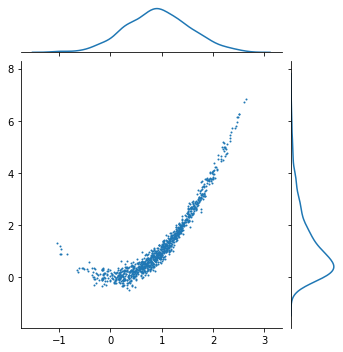

In [4]:
import seaborn as sns

x = pmc.results['samples']
g = sns.JointGrid(height=5)
g.ax_joint.scatter(x[:, 0], x[:, 1], s=1.0)
sns.kdeplot(x=x[:, 0], ax=g.ax_marg_x)
sns.kdeplot(y=x[:, 1], ax=g.ax_marg_y)
plt.show()

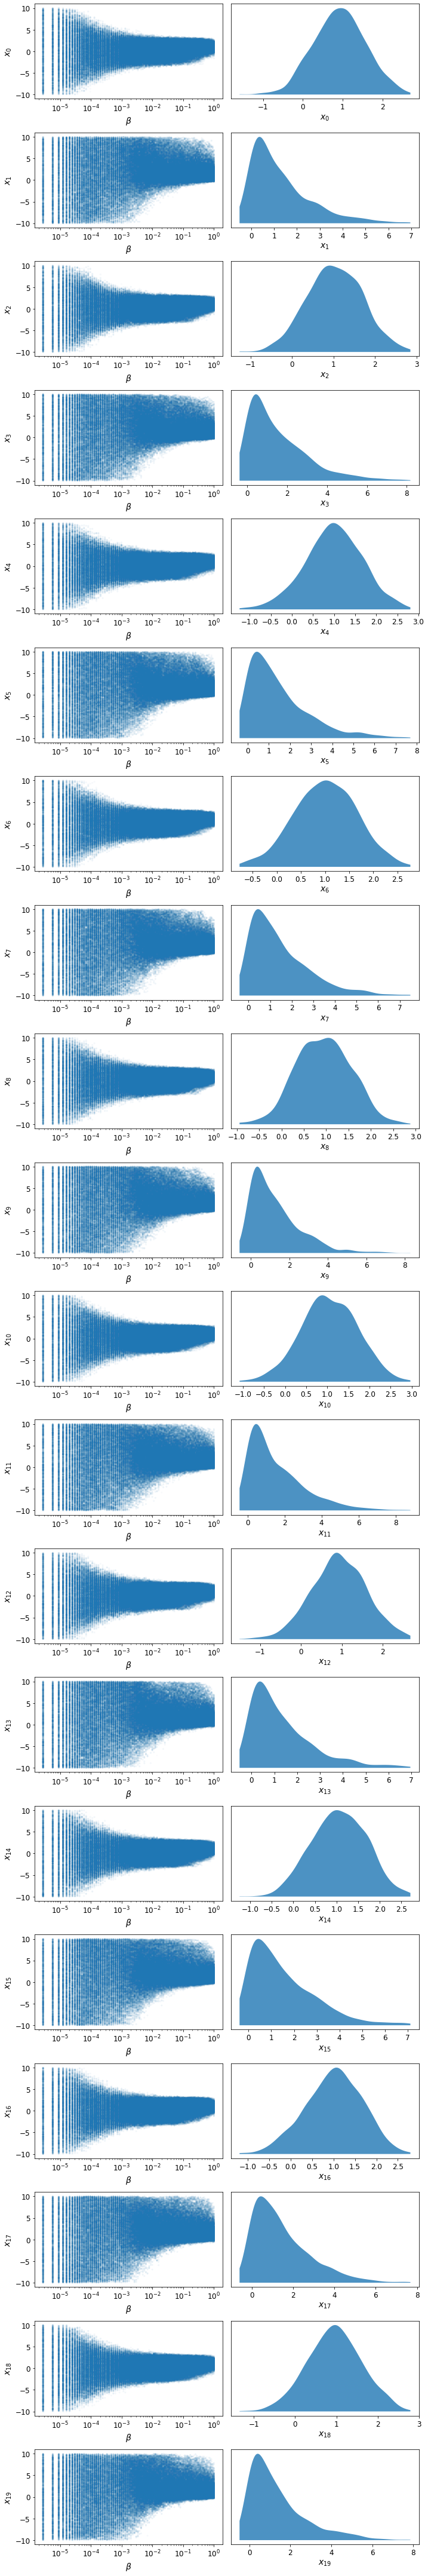

In [5]:
pc.plotting.trace(pmc.results)
plt.show()

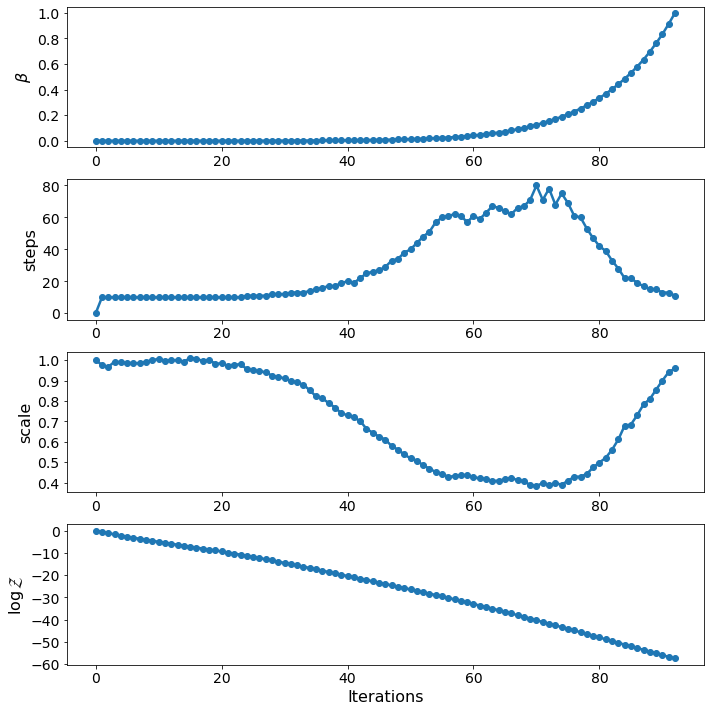

In [6]:
pc.plotting.run(pmc.results)
plt.show()